First, import the necessary packages.

In [1]:
#Import the libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt


In VAEs, the sampling layer uses the output from two dense layers, z_mean and z_log_var, as inputs, followed by converting them into the normal distribution and passing them to the decoder layer.

In [2]:
#Sampling layer
class Sampling(Layer):

	def call(self, inputs):
		z_mean, z_log_var = inputs
		batch = tf.shape(z_mean)[0]
		dim = tf.shape(z_mean)[1]
		epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
		return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Here, we are defining the architecture of the encoder part of this autoencoder, which takes images as input, followed by encoding their representation in the sampling layer.

In [3]:
# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In this step, we are defining the architecture of the decoder part of the autoencoder, where the output of the sampling layer is given as input and produces an output image of size (28, 28, 1) .

In [4]:
# Define Decoder Architecture
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In this step, we are defining the complete variational autoencoder architecture, followed by defining the training procedure with loss functions.

In [5]:
#Define the complete variational autoencoder architecture
class VAE(keras.Model):
	def __init__(self, encoder, decoder, **kwargs):
		super(VAE, self).__init__(**kwargs)
		self.encoder = encoder
		self.decoder = decoder

	def train_step(self, data):
		if isinstance(data, tuple):
			data = data[0]
		with tf.GradientTape() as tape:
			z_mean, z_log_var, z = encoder(data)
			reconstruction = decoder(z)
			reconstruction_loss = tf.reduce_mean(
				keras.losses.binary_crossentropy(data, reconstruction)
			)
			reconstruction_loss *= 28 * 28
			kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
			kl_loss = tf.reduce_mean(kl_loss)
			kl_loss *= -0.5
			total_loss = reconstruction_loss + kl_loss
		grads = tape.gradient(total_loss, self.trainable_weights)
		self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
		return {
			"loss": total_loss,
			"reconstruction_loss": reconstruction_loss,
			"kl_loss": kl_loss,
		}


Here, we shall train the variational autoencoder model for 100 epochs after importing the fashion MNIST dataset.

In [6]:
#Load the fashion mnist dataset
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)
#Expansion of dimension for adding a color map dimension
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

#Compile and train the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 100, batch_size = 64)


4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/100
1094/1094 [==============================] - 19s 7ms/step - loss: 297.6156 - reconstruction_loss: 293.9302 - kl_loss: 3.6853
Epoch 2/100
1094/1094 [==============================] - 7s 6ms/step - loss: 271.5265 - reconstruction_loss: 267.9946 - kl_loss: 3.5319
Epoch 3/100
1094/1094 [==============================] - 7s 7ms/step - loss: 267.0259 - reconstruction_loss: 263.5537 - kl_loss: 3.4722
Epoch 4/100
1094/1094 [==============================] - 7s 6ms/step - loss: 264.2643 - reconstruction_loss: 260.7799 - kl_loss: 3.4843
Epoch 5/100
1094/1094 [==============================] - 9s 8ms/step - loss: 262.4285 - reconstruction_loss: 258.9447 - kl_loss: 3.4838
Epoch 6/100
1094/1094 [==============================] - 7s 6ms/step - loss: 261.3201 - reconstruction_loss: 257.8223 - kl_loss: 3.4978
Epoch 7/100
1094/1094 [==============================] - 7s 7ms/step - loss: 260.4314 - reconstruction_loss: 256.9193 - 

Here we are displaying training results according to their latent space vectors.

1/1 [==============================] - 0s 17ms/step


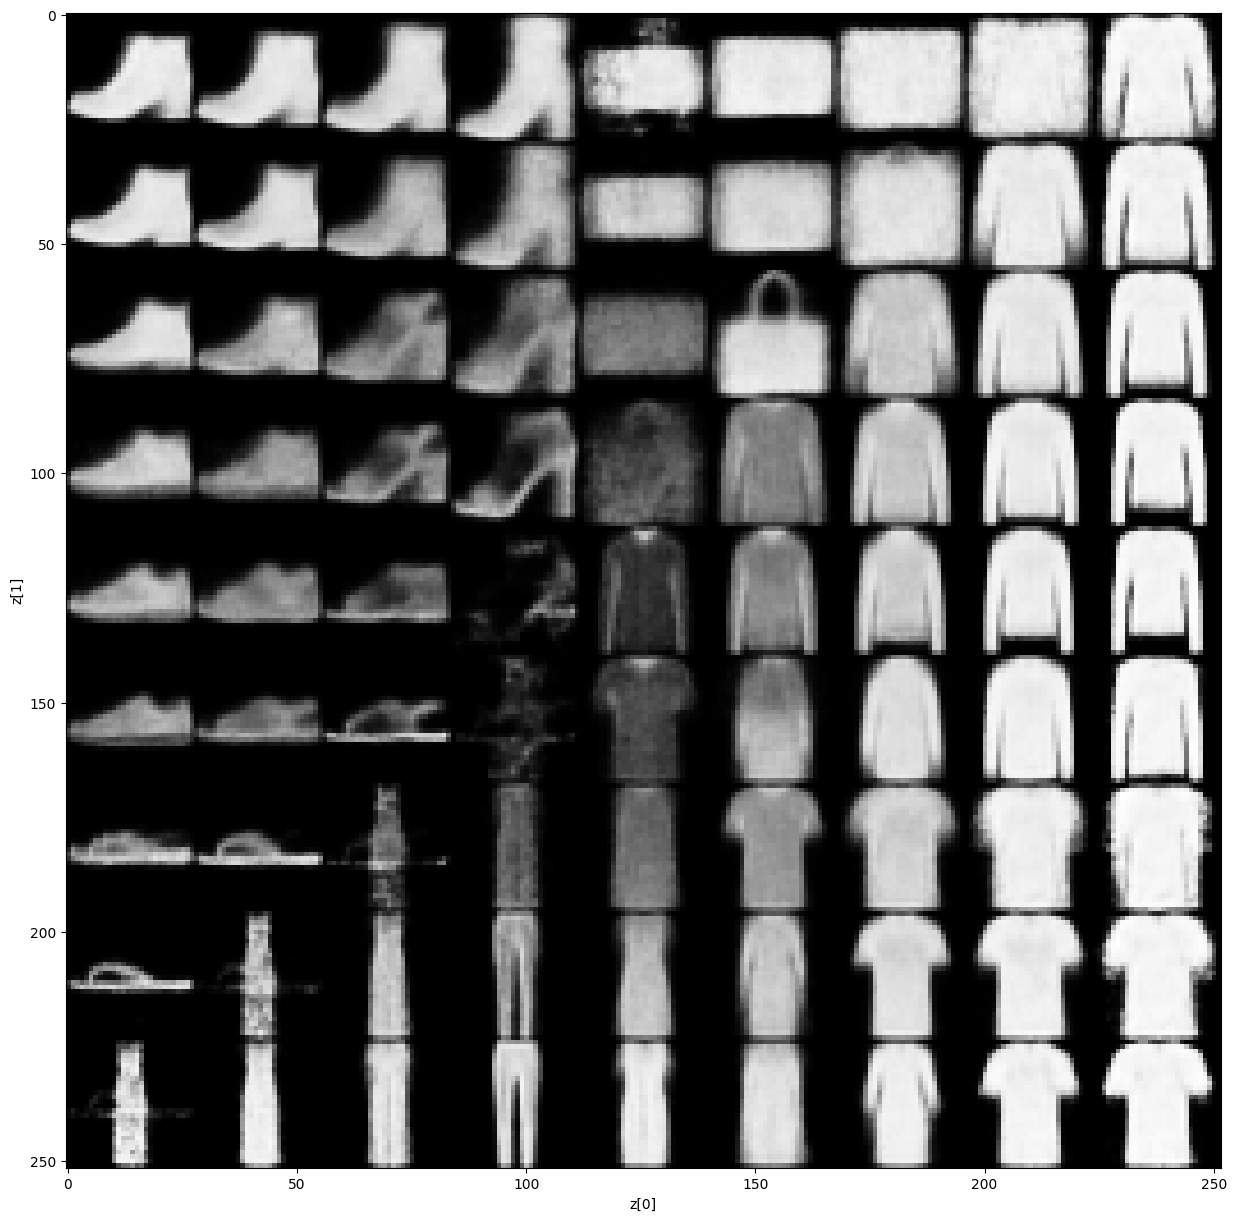

In [7]:
def plot_latent(encoder, decoder):
	n = 9
	img_dim = 28
	scale = 2.0
	figsize = 15
	figure = np.zeros((img_dim * n, img_dim * n))

	grid_x = np.linspace(-scale, scale, n)
	grid_y = np.linspace(-scale, scale, n)[::-1]

	for i, yi in enumerate(grid_y):
		for j, xi in enumerate(grid_x):
			z_sample = np.array([[xi, yi]])
			x_decoded = decoder.predict(z_sample)
			images = x_decoded[0].reshape(img_dim, img_dim)
			figure[
				i * img_dim : (i + 1) * img_dim,
				j * img_dim : (j + 1) * img_dim,
			] = images

	plt.figure(figsize =(figsize, figsize))
	start_range = img_dim // 2
	end_range = n * img_dim + start_range + 1
	pixel_range = np.arange(start_range, end_range, img_dim)
	sample_range_x = np.round(grid_x, 1)
	sample_range_y = np.round(grid_y, 1)
	#plt.xticks(pixel_range, sample_range_x)
	#plt.yticks(pixel_range, sample_range_y)
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.imshow(figure, cmap ="Greys_r")
	plt.show()


plot_latent(encoder, decoder)


The scatter plot of the training data generated from the encoder has been generated to get a clear idea of the latent vector values.

1875/1875 [==============================] - 3s 2ms/step


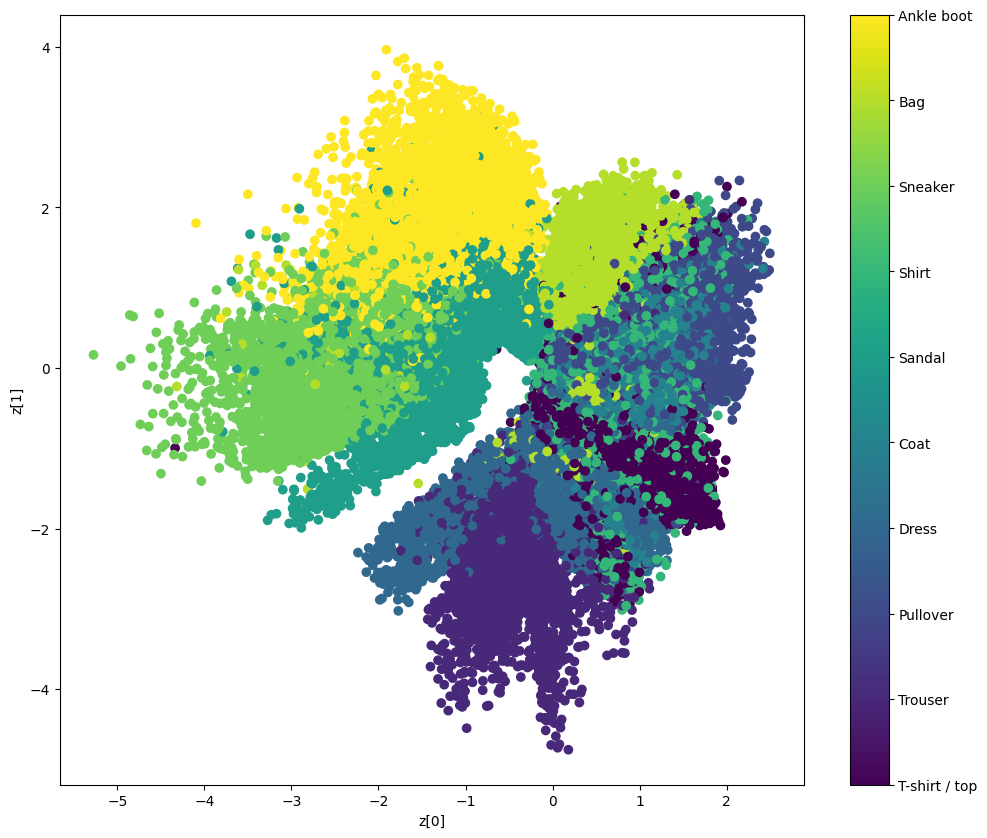

In [8]:
def plot_label_clusters(encoder, decoder, data, test_lab):
	z_mean, _, _ = encoder.predict(data)
	plt.figure(figsize =(12, 10))
	sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
	cbar = plt.colorbar(sc, ticks = range(10))
	cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
	plt.xlabel("z[0]")
	plt.ylabel("z[1]")
	plt.show()


labels = {0 :"T-shirt / top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
